In [1]:
import pandas as pd
import numpy as np
import csv
import json
import re
import matplotlib.pyplot as plt
import os
import os.path
import geopandas

In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

# Dissecting the INC Vote: Do They Matter?

The Iglesia ni Cristo (INC) is very-much known for their practice of bloc-voting every elections. The INC is the third biggest religious group in the Philippines, next to Roman Catholics and the Muslims. With a total population of about 2,000,000, many politicians are wooing the INC vote to get a boost in their candidacy.

Let's try to look at first where majority of the INC population are from the Census data.

### IGLESIA NI CRISTO: Where are they?

#### The group of codes below is used figure out where most of the Iglesia ni Cristo population is in the Philippines. First, an empty list 'census_files' is created. This will contain all the directories or paths containing the Excel (.xls) statistical files for each region and provinces. This was generated by running the os.walk method in the '/mnt/data/public/census/' directory. This was then filtered to remove the files with the regional data (e.g. '_NCR', '_ARMM', etc.), leaving only the statistical files for each province. 

#### The list of provinces were extracted from the concatenated 'census_str' from 'census_files' and were placed into the 'locs' list variable. The INC and total populations per province were extracted by looping through each Excel (.xls) file in the 'census_files' list. The INC populations were appended into 'pops_list', while the total population for each province were appended to 'province_pop'.

#### Finally, the dictionary 'inc_dict' was created to contain the INC population count for each of the province (by zipping 'locs' and 'pops_list'. This will be converted into a Series later on in the report.

In [4]:
# Returns a list with all the directories containing the census XLS
census_files = []
for sd1, sd2, sd3 in os.walk('/mnt/data/public/census/'):
    for file in sd3:
        census_files.append(os.path.join(sd1, file))

# Cleaning up the list by removing those with '_' as these are regional data
census_files = [x for x in census_files if not x.startswith(
    '/mnt/data/public/census/_')]
census_files = sorted(census_files)

# Getting all the provinces
census_str = ('\n'.join(census_files))
locations = re.findall(
    r'\/mnt\/data\/public\/census'
    r'\/(.*?)'
    r'_Statistical Tables_?0?\.xls', census_str)
locs = list(set(locations))
locs = sorted(locs)

# Getting the INC and total populations per province
pops_list = []
province_pop = []
for file in census_files:
    df = pd.read_excel(file, sheet_name='T8', header=None,
                       names=['Religion', 'Both Sexes', 'Male', 'Female'],
                       index_col=0, skiprows=5)
    inc_population = df.loc['Iglesia ni Cristo'][0]
    total_population = df.loc['Total'][0]
    pops_list.append(inc_population)
    province_pop.append(total_population)

# Creates a dictionary with 'locs' as key and each element in 'pops_list'
# as value
inc_dict = dict(zip(locs, pops_list))

#### This code will show the top provinces with the most Iglesia ni Cristo members in a pandas DataFrame and a matplotlib figure. Additional columns were also appended into the data frame to show the total population of the province (Total Province Population), and the percentage (rounded into two decimal places) of the INC members in that province (% INC) compared to the total province population. This is sorted by the number of Iglesia ni Cristo members per province.

,Location,INC Population,Total Province Population,% INC
0,Nueva Ecija,137358.0,2151461.0,6.38
1,Cavite,134345.0,3678301.0,3.65
2,Rizal,129349.0,2884227.0,4.48
3,Quezon,127032.0,2936116.0,4.33
4,Bulacan,126210.0,3292071.0,3.83
5,Tarlac,109995.0,1366027.0,8.05
6,Pangasinan,107462.0,2956726.0,3.63
7,Laguna,88592.0,3035081.0,2.92
8,Pampanga,84436.0,2198110.0,3.84
9,Isabela,73133.0,1593566.0,4.59


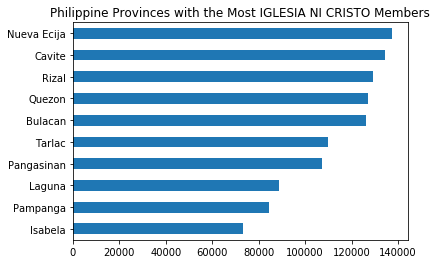

In [5]:
# Creating the dataframe with columns 'Location', 'INC Population', 'Total
# Population' and '% INC' and showing the matplotlib figure
df_inc_pop = pd.DataFrame(inc_dict.items(), index=locs,
                          columns=['Location', 'INC Population'])
df_inc_pop['Total Province Population'] = province_pop
df_inc_pop['% INC'] = df_inc_pop.apply(lambda x: round(
    (x['INC Population'] / x['Total Province Population']) * 100, 2), axis=1)
df_inc_pop = df_inc_pop.sort_values('INC Population', ascending=False)
df_inc_pop_top = df_inc_pop.head(10)
df_inc_pop_top['INC Population'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Philippine Provinces with the Most IGLESIA NI CRISTO Members')
df_inc_pop_top.append(df_inc_pop_top.sum(numeric_only=True),
                      ignore_index=True)

From the table and figure above, we can see that most of the INC members are concentrated in Luzon. With the exception of Pangasinan and Isabela, majority of the most populated INC provinces are from the Central Luzon (Region III) and CALABARZON (Region IV-A) regions.

It is quite a different story when we look at the density though, or when we check the INC population and compare it to the province's population (see '% INC' column above). On this perspective, Tarlac is the most dense INC province, with 8.05% of the population identified as Iglesia ni Cristo. **The top 10 provinces consist 45.7% of the whole Iglesia ni Cristo population nationwide.**

We can see this further in the geographic heatmap below.

#### This code loads the dataframe containing the INC population in a geopandas heatmap. This emphasizes visually the provinces in the Philippines were most INC members are situated. The shapes file are downloaded from the GADM website (https://gadm.org/data.html) and must be loaded to view the heatmap.

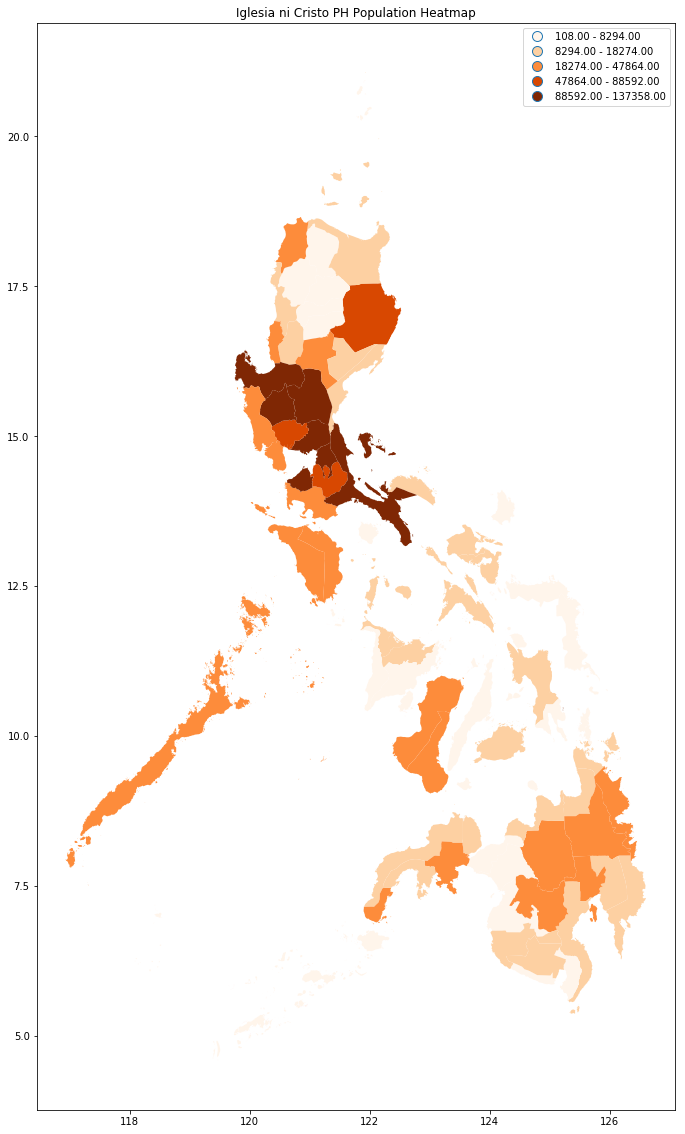

In [6]:
# Loading the shapes file and merging the geo data frame and the INC
# population dataframe
ph1 = geopandas.GeoDataFrame.from_file("./PHL_adm_shp/gadm36_PHL_1.shp")
df_geo_merge = pd.merge(ph1, df_inc_pop, left_on='NAME_1',
                        right_on='Location')
ax = df_geo_merge.plot(column='INC Population', cmap='Oranges',
                       figsize=(15, 20), scheme='fisher_jenks', k=5,
                       legend=True)
ax.set_title("Iglesia ni Cristo PH Population Heatmap");


### Looking at the Votes: The Power of INC Bloc-Voting

In this report, we will try to look at the results of the 2016 Vice Presidential Race and the most recent 2019 Senatorial Elections.

Last 2016, the INC endorsed Bongbong Marcos, an independent candidate then, over Leni Robredo running under the Liberal Party. Marcos and Robredo are the closest competitors in the final pre-election surveys weeks before the election.

Meanwhile, in the recent 2019 senatorial elections, the INC endorsed the following senatorial candidates:

- Sonny Angara 
- Nancy Binay 
- Pia Cayetano
- Ronald Dela Rosa 
- Jinggoy Estrada 
- Christopher "Bong" Go 
- Lito Lapid
- Imee Marcos
- Grace Poe
- Ramon "Bong" Revilla, Jr. 
- Francis Tolentino
- Cynthia Villar

From these, nine are backed by the administration's regional party, Hugpong ng Pagbabago. Only Lapid, Poe and Binay are not from HNP. Grace Poe is an independent candidate, while Lapid is from the Nationalist People's Coalition (NPC) and Binay is from the United Nationalist Alliance (UNA). 

Let us see how these candidates fared in the Top 10 provinces where most INC voters are.

### The 2016 VP Race

#### The code below finds all the directories which contains all files containing the string 'VICE-PRESIDENT PHILIPPINES' under the '/mnt/data/public/elections/nle2016' directory. The counting of votes will be based on ER results, which are the .json files found at the lowest level of the sub-directories. These .json files at the lowest level are seperated per position level, with filenames separated by same.

#### Example:

#### Below are the .json files under '/mnt/data/public/elections/nle2016/PHILIPPINES/ARMM/BASILAN/AKBAR/CADDAYAN/07080004'. We are only interested with the .json files containing the 'VICE-PRESIDENT PHILIPPINES' string in all sub-directories:

'ASSEMBLYMAN BASILAN - LONE REGDIST.json'                          'PROVINCIAL GOVERNOR BASILAN.json'
'MAYOR BASILAN - AKBAR.json'                                       'PROVINCIAL VICE-GOVERNOR BASILAN.json'
'MEMBER, HOUSE OF REPRESENTATIVES BASILAN - LONE LEGDIST.json'     'REGIONAL GOVERNOR ARMM.json'
'MEMBER, SANGGUNIANG BAYAN BASILAN - AKBAR  - LONE DIST.json'      'REGIONAL VICE-GOVERNOR ARMM.json'
'MEMBER, SANGGUNIANG PANLALAWIGAN BASILAN - SECOND PROVDIST.json'  'SENATOR PHILIPPINES.json'
'PARTY LIST PHILIPPINES.json'                                      'VICE-MAYOR BASILAN - AKBAR.json'
'PRESIDENT PHILIPPINES.json'                                       'VICE-PRESIDENT PHILIPPINES.json'

In [7]:
election_2016 = !find /mnt/data/public/elections/nle2016 -type f -name '*VICE-PRESIDENT PHILIPPINES*'

#### The 'vp_list' came from the ER .json files. The 'bName' key identifies the candidates for the post.

In [8]:
vp_list = ['CAYETANO, ALAN PETER (IND)', 'ESCUDERO, CHIZ (IND)',
           'HONASAN, GRINGO (UNA)', 'MARCOS, BONGBONG (IND)',
           'ROBREDO, LENI DAANG MATUWID (LP)', 'TRILLANES, ANTONIO IV (IND)']

In [9]:
def get_votes_vp(location):
    """
    Return a pandas Series which contains the vote counts per location of 
    the VP candididates in the 2016 Philippine election

    Parameters
    ----------
    location : str
        A string containing the specific location or string portion
        from the directory which we want to count the votes

    Returns
    -------
    Series
        Contains the candidates per location with the vote count
    """
    vote_counts = [0] * 6
    for file in election_2016:
        if location in file:
            with open(file) as json_file:
                data = json.load(json_file)
                try:
                    for i in range(6):
                        vote_counts[i] += int(data['results'][i]['votes'])
                except:
                    continue
    return pd.Series({vp_list[i]: vote_counts[i]
                      for i in range(6)}).sort_values(ascending=False)

#### The code below is used to show the horizontal bar graphs containing the results of the VP candidates in the 10 locations where there are the most INC members.

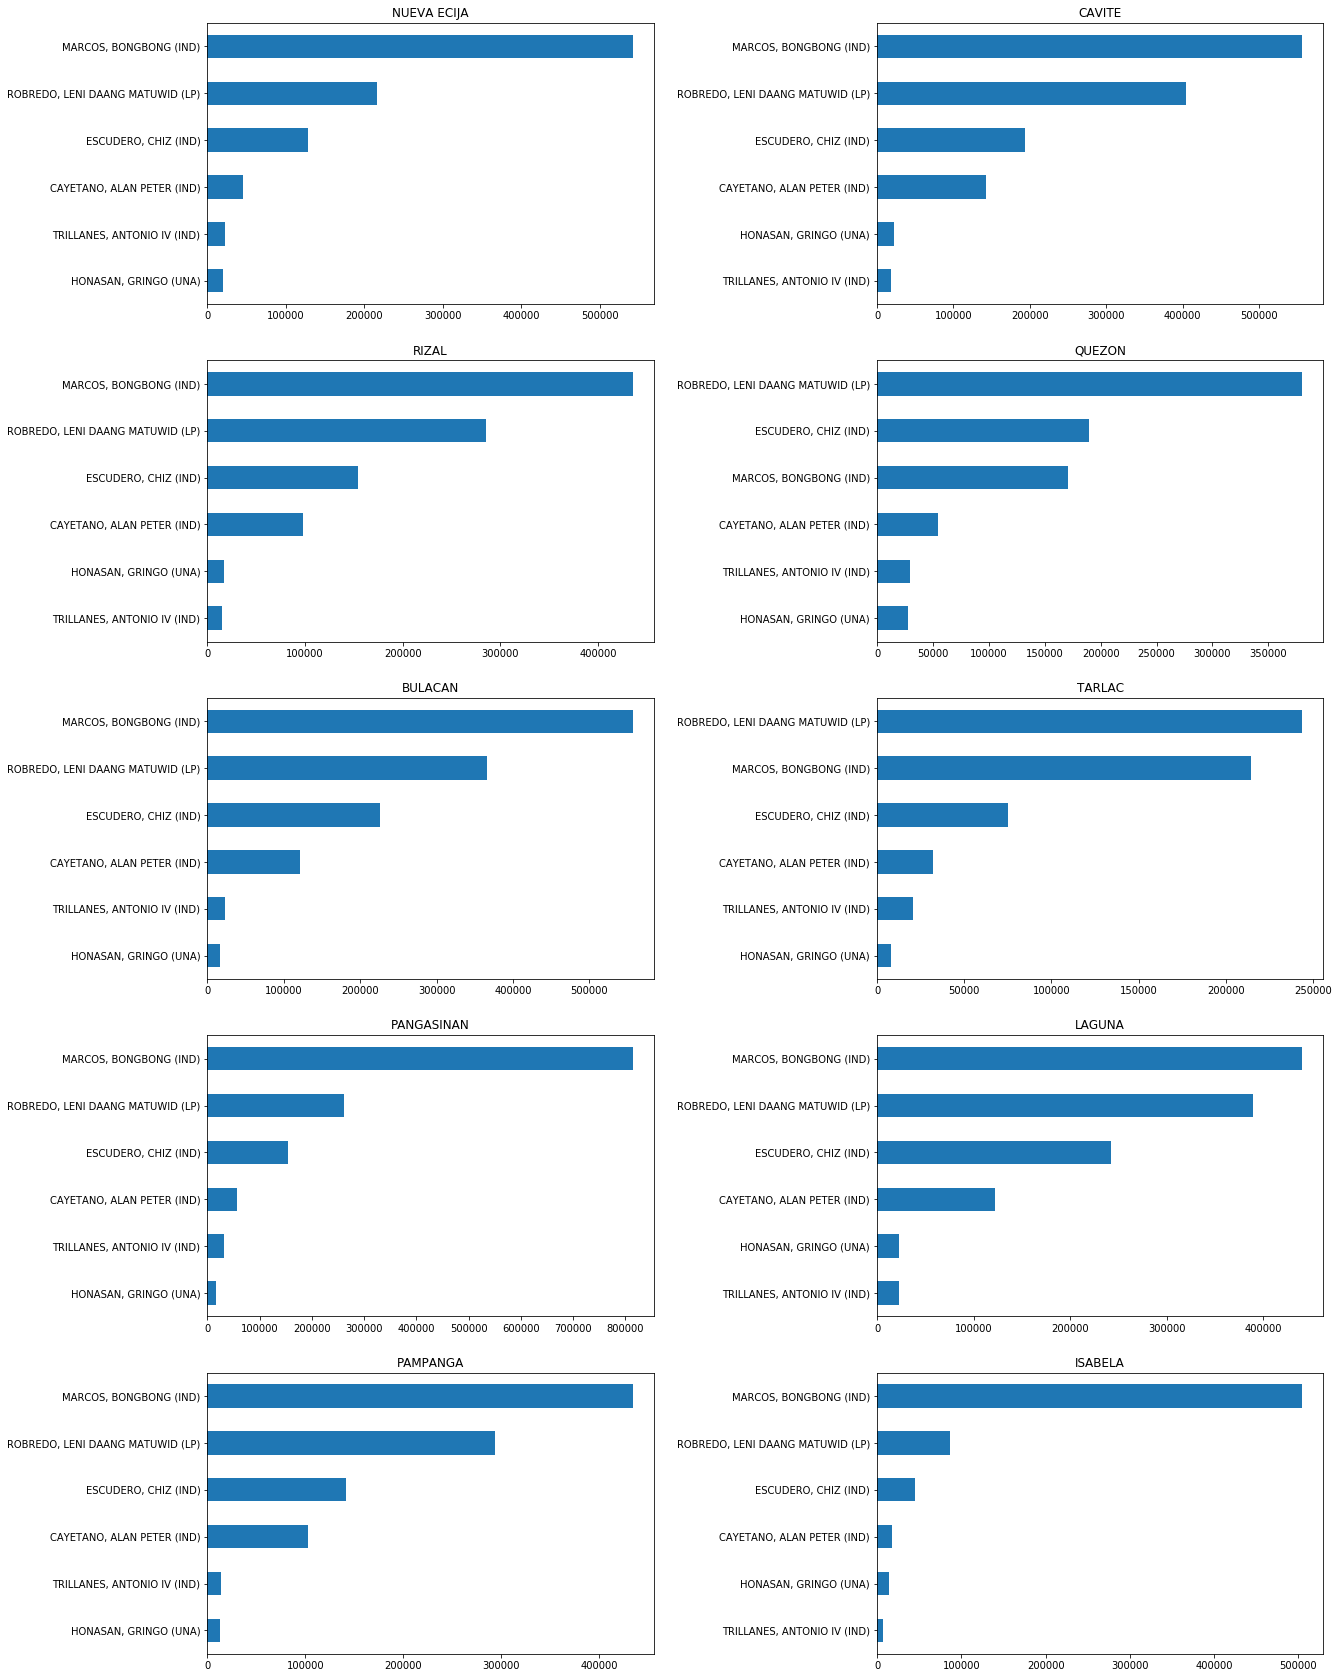

In [10]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),
      (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(20, 30))
get_votes_vp('REGION III/NUEVA ECIJA').plot(kind='barh', ax=ax1).invert_yaxis()
get_votes_vp('REGION IV-A/CAVITE').plot(kind='barh', ax=ax2).invert_yaxis()
get_votes_vp('REGION IV-A/RIZAL').plot(kind='barh', ax=ax3).invert_yaxis()
get_votes_vp('REGION IV-A/QUEZON').plot(kind='barh', ax=ax4).invert_yaxis()
get_votes_vp('REGION III/BULACAN').plot(kind='barh', ax=ax5).invert_yaxis()
get_votes_vp('REGION III/TARLAC').plot(kind='barh', ax=ax6).invert_yaxis()
get_votes_vp('REGION I/PANGASINAN').plot(kind='barh', ax=ax7).invert_yaxis()
get_votes_vp('REGION IV-A/LAGUNA').plot(kind='barh', ax=ax8).invert_yaxis()
get_votes_vp('REGION III/PAMPANGA').plot(kind='barh', ax=ax9).invert_yaxis()
get_votes_vp('REGION II/ISABELA').plot(kind='barh', ax=ax10).invert_yaxis()
ax1.set_title('NUEVA ECIJA')
ax2.set_title('CAVITE')
ax3.set_title('RIZAL')
ax4.set_title('QUEZON')
ax5.set_title('BULACAN')
ax6.set_title('TARLAC')
ax7.set_title('PANGASINAN')
ax8.set_title('LAGUNA')
ax9.set_title('PAMPANGA')
ax10.set_title('ISABELA')
fig.subplots_adjust(wspace=0.5)

It can be seen that **Marcos led the race in 8 out of the 10 INC provinces**, with a very confident lead in Isabela, Pangasinan, Bulacan, Rizal, Cavite and Nueva Ecija. Aside from the INC backing, it must also be noted that there is this so called **"Solid North"** which refers to the strong electoral support of northern provinces near the Ilocos region to the family of former President Ferdinand Marcos.

Robredo led the Tarlac race with a relatively small margin compared to Marcos' lead in other provinces. This despite the province being an Aquino bailwick, the hometown of then president Noynoy Aquino. The INC endorsement, among other factors, could have helped Marcos narrow Robredo's dominance in this province. She meanwhile led the Quezon race with a very wide margin, followed by Chiz Escudero.

In the final official results, sans the INC backing, **Robredo still won but with a very small margin of 0.6%.** This translates to only about 260,000 votes.

### The 2019 Senatorial Race

#### This code finds all the directories which contains all files under the '/mnt/data/public/elections/nle2019/results' directory. The list was filtered to remove the 'info.json' and 'coc.json' files. The counting of votes will be based on ER results, which are the .json files found at the lowest level of the directories.

#### Example:

#### Below are the .json files under '/mnt/data/public/elections/nle2019/results/CAR/ABRA/PILAR/OCUP'. The query below will get all the files available in the given directory and will filter out the 'info.json' and 'coc.json' files. Among those that will be filtered is the 'info.json' file below:

01190013.json  info.json

In [11]:
# Getting all the directories of the 2019 ERs
election_2019 = !find /mnt/data/public/elections/nle2019/results -type f
election_2019 = [x for x in election_2019 if not 'info.json' in x]
election_2019 = [x for x in election_2019 if not 'coc.json' in x]

#### The candidates in the ER results are only assigned a sort of like candidate code or a key 'rs'. The corresponding candidates assigned to each code can be found in the 1.json file found under directory 'mnt/data/public/elections/nle2019/contests/'. A dictionary 'candidate_list' was made to identify who the candidate is per code or per key 'rs'.

In [12]:
# Getting the candidates list
with open('/mnt/data/public/elections/nle2019/contests/1.json') as json_file:
    data = json.load(json_file)

candidate_list = {i['boc']: i['bon'] for i in data['bos']}

In [13]:
def get_votes(location):
    """
    Return a pandas Series which contains the Top 15 candididates
    of the given location. This also counts the total count of votes per
    candidate on that location

    Parameters
    ----------
    location : str
        A string containing the specific location or string portion
        from the directory which we want to count the votes

    Returns
    -------
    Series
        Contains the top 15 candidates per location with the vote count
    """
    vote_counts = [0] * 62
    for file in election_2019:
        if location in file:
            with open(file) as json_file:
                data = json.load(json_file)
                try:
                    for i in range(62):
                        vote_counts[i] += data['rs'][i]['v']
                except:
                    continue
    return pd.Series({candidate_list[i+1]: vote_counts[i]
                      for i in range(62)}).sort_values(ascending=False).head(15)

#### The code below is used to show the horizontal bar graphs containing the results of the Top 15 senate candidates in the 10 locations where there are the most INC members.

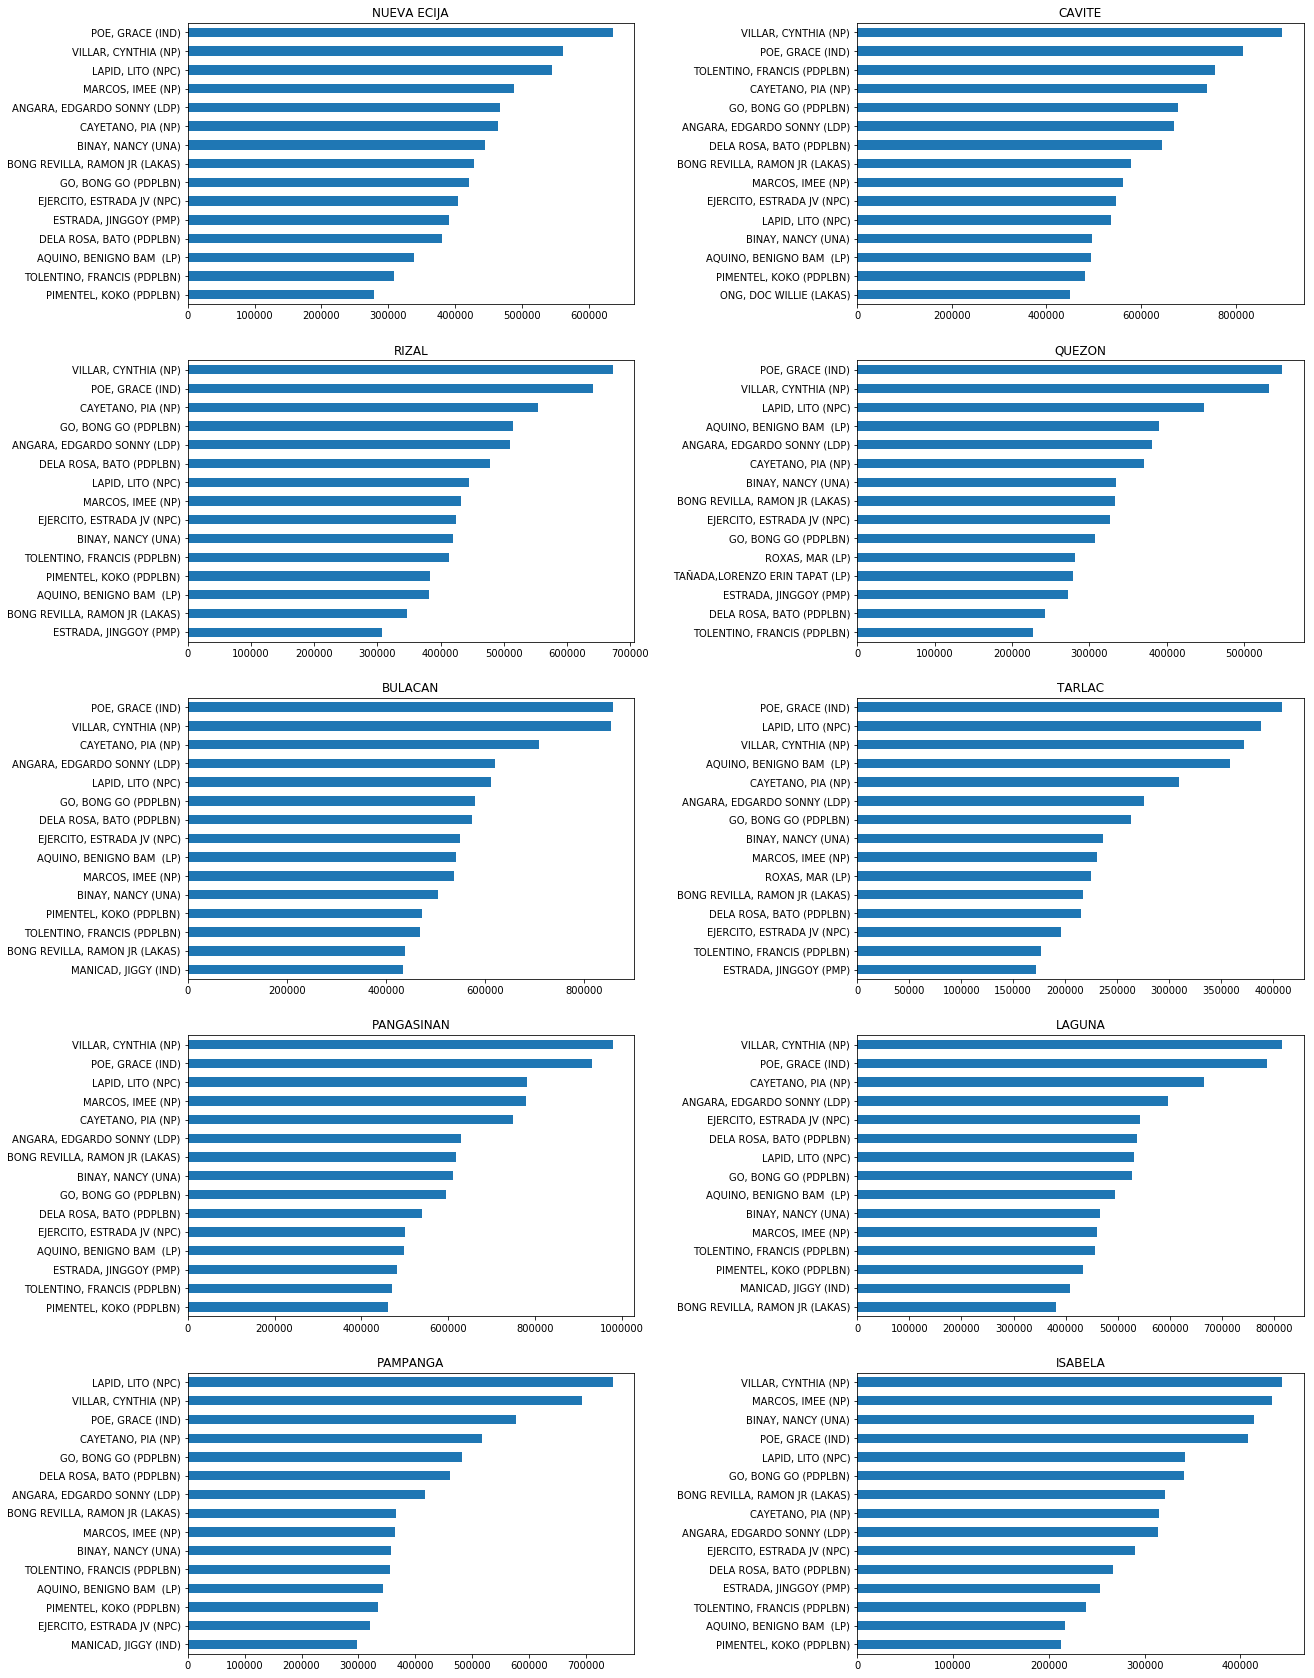

In [14]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),
      (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(20, 30))
get_votes('REGION III/NUEVA ECIJA').plot(kind='barh', ax=ax1).invert_yaxis()
get_votes('REGION IV-A/CAVITE').plot(kind='barh', ax=ax2).invert_yaxis()
get_votes('REGION IV-A/RIZAL').plot(kind='barh', ax=ax3).invert_yaxis()
get_votes('REGION IV-A/QUEZON').plot(kind='barh', ax=ax4).invert_yaxis()
get_votes('REGION III/BULACAN').plot(kind='barh', ax=ax5).invert_yaxis()
get_votes('REGION III/TARLAC').plot(kind='barh', ax=ax6).invert_yaxis()
get_votes('REGION I/PANGASINAN').plot(kind='barh', ax=ax7).invert_yaxis()
get_votes('REGION IV-A/LAGUNA').plot(kind='barh', ax=ax8).invert_yaxis()
get_votes('REGION III/PAMPANGA').plot(kind='barh', ax=ax9).invert_yaxis()
get_votes('REGION II/ISABELA').plot(kind='barh', ax=ax10).invert_yaxis()
ax1.set_title('NUEVA ECIJA')
ax2.set_title('CAVITE')
ax3.set_title('RIZAL')
ax4.set_title('QUEZON')
ax5.set_title('BULACAN')
ax6.set_title('TARLAC')
ax7.set_title('PANGASINAN')
ax8.set_title('LAGUNA')
ax9.set_title('PAMPANGA')
ax10.set_title('ISABELA')
fig.subplots_adjust(wspace=0.5)

Almost all of the INC-endorsed senatorial candidates made it in the Top 15 of the provinces with the most Iglesia ni Cristo population.

From the 12 candidates endorsed by the Iglesia ni Cristo, 10 candidates have consistently made it to the Top 15 across provinces. Marcos was not in the Top 15 for Quezon, while Estrada was not in the Top 15 for Laguna, Bulacan, Quezon and Cavite. Interestingly, Aquino and Ejercito still managed to consistently enter the Top 15 despite being not endorsed by INC.

Aquino only managed to get the 4th spot in Tarlac, despite it being an Aquino bailwick. The INC vote may have played its role here, among other factors, as the top 3 candidates above him are all endorsed by the  INC. He was the only opposition candidate who was able to get a slot in the Top 5 (in Tarlac and Quezon) sans the INC endorsement.

Based on the 2016 article by the Inquirer (https://opinion.inquirer.net/94838/do-inc-votes-matter), around 75% of the INC members vote according to the endorsements made by ther leaders. This is based on the exit polls conducted by SWS after the elections.

Using this data, we may infer that if there is a tight contest between two candidates for the 12th Senate seat, INC vote may swing the tide favoring the INC-officially endorse candidate.

In [17]:
# Getting all the votes for the whole Philippines
get_votes('/mnt/data/public/elections/nle2019')

VILLAR, CYNTHIA (NP)              25119270
POE, GRACE (IND)                  21913372
GO, BONG GO (PDPLBN)              20456891
CAYETANO, PIA (NP)                19635682
DELA ROSA, BATO (PDPLBN)          18805968
ANGARA, EDGARDO SONNY (LDP)       18043625
LAPID, LITO (NPC)                 16881719
MARCOS, IMEE (NP)                 15732733
TOLENTINO, FRANCIS (PDPLBN)       15370672
PIMENTEL, KOKO (PDPLBN)           14550540
BONG REVILLA, RAMON JR (LAKAS)    14547352
BINAY, NANCY (UNA)                14449334
EJERCITO, ESTRADA JV (NPC)        14226357
AQUINO, BENIGNO BAM  (LP)         14081431
ESTRADA, JINGGOY (PMP)            11306655
dtype: int64

Getting 75% of the total voting population who identify themselves as INC members, the amount is **1,976,296 strong**.

Looking at the results of the election, INC-endorsed candidates Bong Revilla and Nancy Binay got the 11th and 12th spots respectively. Non-INC-endorsed candidates JV Ejercito and Bam Aquino got the 13th and 14th spot.

Revilla got 14,547,352 votes while Bam Aquino got 14,081,431, a difference of 465,921. The amount of INC voters were more than enough to put both JV Ejercito and Bam Aquino in the winner list of the 2019 Senate Race.

With this, there is strong reason to believe that INC votes do matter in swinging the tide of a **close race between two political candidates** in the national level.

We also tried to compare the results of the Senatorial race in the **provinces with the least INC population** (Batanes, Sulu, Tawi-Tawi, Isabela and Basilan) with the results of the Top 10 INC provinces.

#### Here, we add the votes from the Top 10 INC provinces and the 5 provinces with the least INC population. The number of NaN's in the total votes column indicate that the candidate was not consistently present in the Top 15 of the provinces added (i.e. adding a candidate vote to a NaN or when he is not in the Top 15 will result to a NaN).

In [18]:
top_inc = (get_votes('REGION III/NUEVA ECIJA')
           + get_votes('REGION IV-A/CAVITE')
           + get_votes('REGION IV-A/RIZAL')
           + get_votes('REGION IV-A/QUEZON')
           + get_votes('REGION III/BULACAN')
           + get_votes('REGION III/TARLAC')
           + get_votes('REGION I/PANGASINAN')
           + get_votes('REGION IV-A/LAGUNA')
           + get_votes('REGION III/PAMPANGA')
           + get_votes('REGION II/ISABELA'))

print("TOTAL VOTES FOR THE TOP 10 MOST INC POPULATED PROVINCES")
print(top_inc);

least_inc = (get_votes('REGION II/BATANES') + get_votes('ARMM/SULU')
           + get_votes('ARMM/TAWI-TAWI') + get_votes('REGION II/ISABELA')
           + get_votes('ARMM/BASILAN'))

print("\nTOTAL VOTES FOR THE LEAST 5 INC POPULATED PROVINCES")
print(least_inc);

TOTAL VOTES FOR THE TOP 10 MOST INC POPULATED PROVINCES
ANGARA, EDGARDO SONNY (LDP)       4873850.0
AQUINO, BENIGNO BAM  (LP)         4056549.0
BINAY, NANCY (UNA)                4283339.0
BONG REVILLA, RAMON JR (LAKAS)    4028710.0
CAYETANO, PIA (NP)                5391911.0
DELA ROSA, BATO (PDPLBN)          4337826.0
EJERCITO, ESTRADA JV (NPC)        4099057.0
ESTRADA, JINGGOY (PMP)                  NaN
GO, BONG GO (PDPLBN)              4705384.0
LAPID, LITO (NPC)                 5372632.0
MANICAD, JIGGY (IND)                    NaN
MARCOS, IMEE (NP)                       NaN
ONG, DOC WILLIE (LAKAS)                 NaN
PIMENTEL, KOKO (PDPLBN)                 NaN
POE, GRACE (IND)                  6605473.0
ROXAS, MAR (LP)                         NaN
TAÑADA,LORENZO ERIN TAPAT (LP)          NaN
TOLENTINO, FRANCIS (PDPLBN)       3871205.0
VILLAR, CYNTHIA (NP)              6818046.0
dtype: float64

TOTAL VOTES FOR THE LEAST 5 INC POPULATED PROVINCES
ALEJANO, GARY (LP)                     N

In support of the earlier argument that INC votes have the power to swing two Senate seats to the candidates they favor, the results of getting the senate votes of the top ten INC-heavy regions in the Philippines show that each province consistently has **10 INC endorsed consistently being in the top 15** of the Senator candidates list for that region (12 if we include Ejercito and Aquino, but they are not-INC endorsed). While in the five lowest INC-populated regions, **only 8 of the 12 INC endorsed candidates** (10 if we include Ejercito and Pimentel, but both too are not INC-endorsed) were consistently in the top 15.

### CONCLUSION

The votes of the Iglesia ni Cristo voters does matter, but not for all races and candidates. **Specifically for tight races, the INC vote can be very, very critical.** Note though that it may be hard to determine the effect of the INC votes, especially in large, national races, given that there may be other factors that affect the population voting behavior, including those that are non-INC members.

In the 2016 VP race, the INC vote was very critical. With Robredo leading only with very small margin, every vote, especially those who may have not followed the INC order, mattered. 

In senate races, the INC vote can be a gamechanger in identifying the candidate who will take the last winning spot. In the 2019 senate race, 11 out of the 12 winning candidates are endorsed by INC. Only Pimentel was able to get a slot in the Top 12 even though he was not endorsed by the group.

As mentioned above, there also is a very tight race between the 12th to 14th spot, with Binay only leading Ejercito and Aquino with about 200,000 and 300,000 votes, respectively. Suppose that the INC endorsement had switched from Binay to either Ejercito or Aquino, we probably would have a different set of winners. With an INC endorsement and a full obedience from the members, the battle for the last spot could have been between Ejercito and Aquino, instead of between Binay and Ejercito.

Just a caveat, most of candidates endorsed by Iglesia ni Cristo are already topping the pre-election surveys, so it may be hard to determine if their system of bloc-voting is really potent. They typically release their list just a few days before the election day. In very close races though, the INC vote can still matter. The number of votes INC can bring for a candidate can translate to his victory, especially if his competition is only leading with a very small margin.